 # Scenario 1.1 - Pharmapendium Search

In [1]:
# relevant data paths

hdfs_path = "hdfs://demo-full-load-hdfs-namenode:8020"
pp_drug_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-drug_deduplicated/*.csv'
pp_study_design_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-studydesign_deduplicated/*.csv'
pp_study_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-study_deduplicated/*.csv'
pp_subjects_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-subject_deduplicated/*.csv'
pp_species_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-species_deduplicated/*.csv'
pp_pkparameters_path =  hdfs_path + '/ppplus/elsevier-csv-ppplus-pkparameter_deduplicated/*.csv'
pp_result_path =  hdfs_path + '/ppplus/elsevier-csv-ppplus-result_deduplicated/*.csv'
pp_measure_path =  hdfs_path + '/ppplus/elsevier-csv-ppplus-measure_deduplicated/*.csv'
pp_dosing_regimen = hdfs_path + '/ppplus/elsevier-csv-ppplus-dosingregimen_deduplicated/*.csv'
pp_source_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-source_deduplicated/*.csv'
pp_reference_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-reference_deduplicated/*.csv'
pp_concomitant_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-concomitant_deduplicated/*.csv'
#  import spark related modules
import pyspark
import socket
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct
from pyspark import SparkContext, StorageLevel
from rdkit.Chem.Draw.IPythonConsole import display_pil_image
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem.Draw import MolsToGridImage
from rdkit import Chem
import os , sys
import multiprocessing as mp
import uuid

def add_prefix(sdf, prefix):
    for c in sdf.columns:
        sdf = sdf.withColumnRenamed(c, '{}{}'.format(prefix, c))
    return sdf

# prevent error on rerunning if session is still alive
if 'sc' in globals():
    sc.stop()
    
# most configuration of the sparksession is done for you in the back
application_name = 'Use case 1 - Pharmapendium'

conf = pyspark.SparkConf()\
    .set("spark.driver.memory","10g")\
    .set("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .set("spark.sql.crossJoin.enabled", "true")\
    .set("spark.sql.shuffle.partitions" , 16)\
    .setAppName(application_name).setMaster('local[*]')

sparkSession = SparkSession.builder.appName('job_name')\
                           .config('spark.executor.memory', '4g')\
                           .config('spark.executor.instances', '5')\
                           .config('spark.sql.shuffle.partitions', '50')\
                           .config('spark.driver.memory', '4g')\
                           .config('spark.executor.cores', '3')\
                           .config('spark.driver.host', socket.gethostbyname(socket.gethostname()))\
                           .getOrCreate()

#sparkSession = SparkSession.builder.config(conf=conf).getOrCreate()

sc = sparkSession.sparkContext
sc

<SparkContext master=k8s://https://kubernetes.default.svc.cluster.local:443 appName=job_name>

 ## Data loading and cleaning ##
 The datasets loaded are:
  - Drug
  - Study
  - Study design
  - Subjects
  - Species
  - Measure
  - PK Parameters
  - Results
  - Dosing Regimen
  
 ## Data schema ##
 

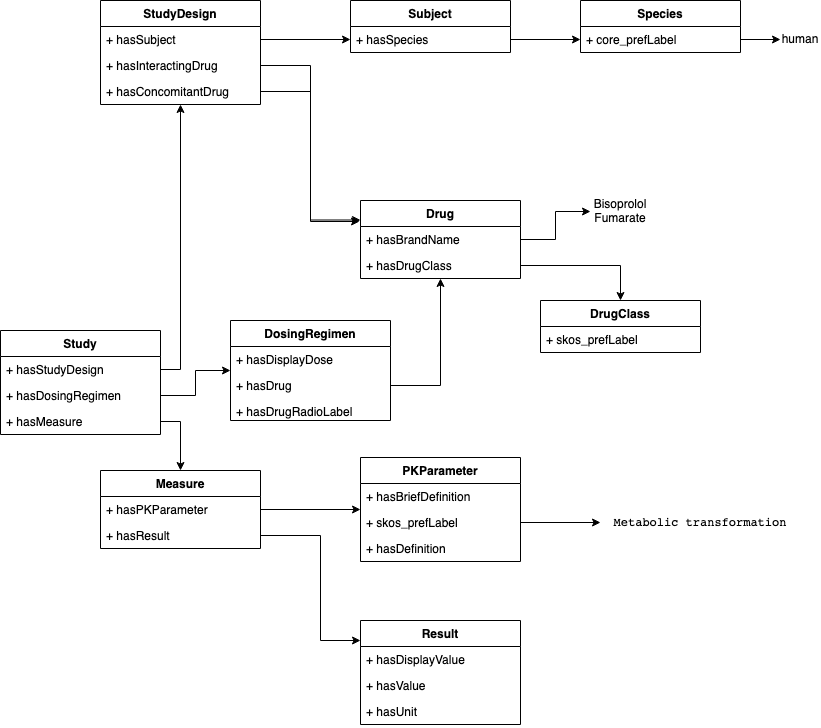

In [2]:
from IPython.display import Image
Image("ppplus.png")

In [3]:
import pprint
from IPython.display import Markdown, display, HTML

ppplus_drug = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_drug_path) \
            .select(["Drug","hasName","hasSmiles"]) \
            .withColumnRenamed('hasName','drugName') \
            .dropDuplicates(['Drug'])
drug = ppplus_drug.alias('drug')

pp_study_design = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_study_design_path) \
            .select(["StudyDesign","hasInteractingDrug","hasConcomitant","hasSubject","hasTarget","hasStudyNumber","hasStudyName"])\
            .dropDuplicates(['StudyDesign'])
study_design = pp_study_design.alias('study_design')

pp_study = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_study_path) \
            .select(["Study","hasStudyDesign","hasDosingRegimen","hasMeasure","hasReference"])\
            .dropDuplicates(['Study'])
study = pp_study.alias('study')

ppplus_subjects = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_subjects_path) \
            .select(["Subject","hasSpecies","hasStudyGroup","hasSex","hasAge"])\
            .dropDuplicates(['Subject'])
subjects = ppplus_subjects.alias('subjects')

ppplus_species = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_species_path) \
            .select(["Species","core_prefLabel"])\
            .withColumnRenamed('core_prefLabel','speciesName') \
            .dropDuplicates(['Species'])
species = ppplus_species.alias('species')

ppplus_pkparameters = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_pkparameters_path) \
            .select(["PKParameter","core_prefLabel"])\
            .withColumnRenamed('core_prefLabel','parameterName') \
            .dropDuplicates(['PKParameter'])
pkparameters = ppplus_pkparameters.alias('pkparameters')

ppplus_result = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_result_path) \
            .select(["Result","hasValue","hasUnit","hasStandardDeviation"])\
            .dropDuplicates(['Result'])
results = ppplus_result.alias('results')

ppplus_measure = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_measure_path) \
            .select(["Measure","hasPKParameter","hasPathogen","hasResult","hasParameterDisplay","hasAnalysisTechnique","hasTimeOfMeasurment"])\
            .dropDuplicates(['Measure']) \
            .na.drop(subset=["hasPKParameter"]) 
measures = ppplus_measure.alias('measures')

ppplus_reference = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_reference_path) \
            .select(["Reference","hasSource","hasDocumentYear"])\
            .dropDuplicates(['Reference'])
references = ppplus_reference.alias('references')

ppplus_concomitant = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_concomitant_path) \
            .select(["Concomitant","core_prefLabel"])\
            .withColumnRenamed('core_prefLabel','ConcomitantName') \
            .dropDuplicates(['Concomitant'])
concomitant = ppplus_concomitant.alias('concomitant')

ppplus_source = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_source_path) \
            .select(["Source","core_prefLabel"])\
            .withColumnRenamed('core_prefLabel','sourceName') \
            .dropDuplicates(['Source'])
sources = ppplus_source.alias('sources')

ppplus_dosing_regimen = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_dosing_regimen) \
            .select(["DosingRegimen","hasDrug","hasDose","hasDoseFrequency", "hasDrugRadioLabel","hasTreatmentDuration","hasRoute","hasDoseComments"])\
            .dropDuplicates(['DosingRegimen'])
dosing_regimen = ppplus_dosing_regimen.alias('dosing_regimen')


In order to count the number of *study* that involve a given drug first one must join the *study_design* with the filtered table of focused *drug*. Then the resulting table is joined with the *study* table and the results are grouped and aggregated by _hasName_ which is the original field of the drug name.

In [19]:
import ipywidgets as widgets
from IPython.core.display import display, HTML
HTML('''<script> </script> <form action="javascript:IPython.notebook.execute_cells_above()"><input type="submit" id="toggleButton" value="Run all above"></form>''')

In [25]:
w = widgets.Dropdown(
    options=['Bisoprolol Fumarate', 'Gefitinib', 'Celecoxib'],
    value='Bisoprolol Fumarate',
    description='Drug:',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print ("changed to %s" % change['new'])

w.observe(on_change)

display(w)

Dropdown(description='Drug:', options=('Bisoprolol Fumarate', 'Gefitinib', 'Celecoxib'), value='Bisoprolol Fum…

In [28]:
#%%time
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import concat, lit, col

focused_drugs = sc.broadcast([ w.value ])
focused_species = sc.broadcast([ "Rat" ])
focused_parameter = sc.broadcast([ "fu", "fu(at 0.3-0.5 ug/mL)" ])

fstudy = study\
     .join(references        , study.hasReference      == references.Reference, how='left')\
     .join(sources           , references.hasSource    == sources.Source, how='left')\
     .join(study_design      , study.hasStudyDesign    == study_design.StudyDesign, how='left')\
     .join(subjects          , study_design.hasSubject == subjects.Subject, how='left')\
     .join(broadcast(species), subjects.hasSpecies     == species.Species , how='left')\
     .join(dosing_regimen    , study.hasDosingRegimen  == dosing_regimen.DosingRegimen , how='left')\
     .join(broadcast(drug)   , dosing_regimen.hasDrug  == drug.Drug , how='left')\
     .join(concomitant       , study_design.hasConcomitant == concomitant.Concomitant, how='left')\
     .join(measures          , study.hasMeasure        == measures.Measure , how='left')\
     .join(results           , measures.hasResult      == results.Result, how ='left')\
     .drop('hasStudyDesign' , 'hasDosingRegimen' , 'hasMeasure' , 'StudyDesign' , 'hasInteractingDrug' ,\
           'hasConcomitantDrug' , 'hasSubject' , 'hasTarget' , 'Subject' , 'hasSpecies' , 'Species' ,\
           'PKParameter' , 'hasMeasure' , 'Measure','Study','hasDosingRegimen','hasDrug',\
           'Drug','hasResult','DosingRegimen','Result', 'hasReference', 'Reference', 'hasSource', 'Source',\
           'Concomitant','hasConcomitant','hasPathogen','hasResult')\
     .withColumnRenamed('drugName','Drug')\
     .withColumnRenamed('hasSmiles','Chemical Structure')\
     .withColumnRenamed('hasDrugRadioLabel','Radiolabelled')\
     .withColumnRenamed('speciesName','Species')\
     .withColumnRenamed('hasStudyNumber','Study Number')\
     .withColumnRenamed('hasStudyGroup','Study Group')\
     .withColumnRenamed('hasStudyName','Study Name')\
     .withColumnRenamed('hasSex','Sex')\
     .withColumnRenamed('hasAge','Age')\
     .withColumnRenamed('hasDose','Dose')\
     .withColumnRenamed('hasTreatmentDuration','Duration')\
     .withColumnRenamed('hasRoute','Route')\
     .withColumnRenamed('hasAnalysisTechnique','Assay')\
     .withColumnRenamed('hasParameterDisplay','Parameter')\
     .withColumnRenamed('hasValue','Parameter Value')\
     .withColumnRenamed('hasUnit','Parameter Value2')\
     .withColumnRenamed('hasStandardDeviation','SD')\
     .withColumnRenamed('hasTimeofMeasurment','t')\
     .withColumnRenamed('ConcomitantName','Concomitants')\
     .withColumnRenamed('hasDoseComments','Comments')\
     .withColumnRenamed('sourceName','Source')\
     .withColumnRenamed('hasDocumentYear','Year')\
     .select("Drug","Chemical Structure","Radiolabelled","Species","Study Number","Study Group","Study Name","Sex","Age","Dose","Duration","Route","Assay","Parameter",concat(col("Parameter Value"),lit(''),col("Parameter Value2")).alias("Parameter Value"),"SD","t","Concomitants","Comments","Source","Year")

     
result = fstudy.where(species.speciesName.isin(focused_species.value)\
                      & drug.drugName.isin(focused_drugs.value)\
                      & measures.hasParameterDisplay.isin(focused_parameter.value)\
                     ).toPandas()

In [29]:
import pandas as pd
with pd.option_context('display.max_rows', 9, 'display.max_columns', None): 
    #display(result)
    display({'text/html': result.to_html()}, raw=True)

,Drug,Chemical Structure,Radiolabelled,Species,Study Number,Study Group,Study Name,Sex,Age,Dose,Duration,Route,Assay,Parameter,Parameter Value,SD,t,Concomitants,Comments,Source,Year


In [18]:
result.to_csv('usecase1_1.csv')